In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from string import Template
from itertools import product


class Instrument:

    def __init__(self,
                 symbol: str,
                 precision: int,
                 name: str):
        self.symbol = symbol
        self.precision = precision
        self.name = name
        
    def __lt__(self, other):
        return self.symbol < other.symbol
        
    def __repr__(self):
        return self.symbol
        
        
class Quantity:

    def __init__(self, amount, instrument):
        self.amount = round(amount, instrument.precision)
        self.instrument = instrument
        self.order = None


class Wallet:

    def __init__(
            self,
            exchange: 'Exchange', 
            instrument: 'Instrument', 
            amount: 'Quantity'
        ):
        self.exchange = exchange
        self.instrument = instrument
        self.amount = amount     
                       
    def send(wallet: 'Wallet', quantity: 'Quantity'):  
        pass

### Instruments

In [155]:
# Fiat-Currency
USD = Instrument('USD', 2, 'U.S. dollar')

# Crypto-Currency
BTC = Instrument('BTC', 8, 'bitcoin')
ETH = Instrument('ETH', 8, 'ethereum')
BCH = Instrument('BTH', 8, 'bitcoin cash')
LTC = Instrument('LTC', 2, 'litecoin')
XRP = Instrument('XRP', 2, 'XRP')

### Topology

6 22


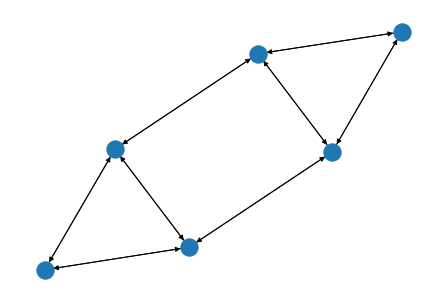

In [166]:
w0 = Wallet('coinbase', USD, Quantity(10000, USD))
w1 = Wallet('coinbase', BTC, Quantity(0.5,     BTC))
w2 = Wallet('coinbase', ETH, Quantity(4,     ETH))
w3 = Wallet('binance' , USD, Quantity(15000, USD))
w4 = Wallet('binance' , BTC, Quantity(3,     BTC))
w5 = Wallet('binance' , ETH, Quantity(10.75,     ETH))


# Vertices
nodes = [
    w0, w1, w2, w3, w4, w5
]


# Edges
edges = [
    (w0, w0), # (coinbase, USD) -> (coinbase, USD)
    (w0, w1), # (coinbase, USD) -> (coinbase, BTC)
    (w0, w2), # (coinbase, USD) -> (coinbase, ETH)
    (w1, w0), # (coinbase, BTC) -> (coinbase, USD)
    (w1, w1), # (coinbase, BTC) -> (coinbase, BTC)
    (w1, w2), # (coinbase, BTC) -> (coinbase, ETH)
    (w1, w4), # (coinbase, BTC) -> (binance , BTC)
    (w2, w0), # (coinbase, ETH) -> (coinbase, USD)
    (w2, w1), # (coinbase, ETH) -> (coinbase, BTC)
    (w2, w2), # (coinbase, ETH) -> (coinbase, ETH)
    (w2, w5), # (coinbase, ETH) -> (binance , ETH)
    (w3, w3), # (binance , USD) -> (binance , USD)
    (w3, w4), # (binance , USD) -> (binance , BTC)
    (w3, w5), # (binance , USD) -> (binance , ETH)
    (w4, w1), # (binance , BTC) -> (coinbase, BTC)
    (w4, w3), # (binance , BTC) -> (binance , USD)
    (w4, w4), # (binance , BTC) -> (binance , BTC)
    (w4, w5), # (binance , BTC) -> (binance , ETH)
    (w5, w2), # (binance , ETH) -> (coinbase, ETH)
    (w5, w3), # (binance , ETH) -> (binance , USD)
    (w5, w4), # (binance , ETH) -> (binance , BTC)
    (w5, w5)  # (binance , ETH) -> (binance , ETH)
]


G = nx.DiGraph()

G.add_nodes_from(nodes)
G.add_edges_from(edges)
print(len(G.nodes), len(G.edges))
nx.draw(G)
plt.show()

## Data (for a single time step)

Below is the data needed to carry out one time step of mixing.

### Compute rate matrix

In [276]:
Q = {
    (('coinbase', USD), ('coinbase', BTC)): 7605.00,
    (('coinbase', USD), ('coinbase', ETH)):  153.91,
    (('binance', USD), ('binance', BTC)): 7625.50,
    (('binance', USD), ('binance', ETH)):  154.22
}


for v1, v2 in edges:
    
    e1, c1 = v1.exchange, v1.instrument
    e2, c2 = v2.exchange, v2.instrument

    # If exchanges are the same and currencies are both not
    # USD and they do not equal each other.
    if c1 != USD and c2 != USD:
        r1 = Q[((e1, USD), (e1, c1))] 
        r2 = Q[((e2, USD), (e2, c2))] 
        
        Q[((e1, c1), (e2, c2))] = (1 / r1)*r2
  
    if e1 == e2 and c1 == USD and c2 == USD:
        Q[((e1, USD), (e2, c2))] = 1.0
        
    if e1 == e2 and c1 != USD and c2 == USD:
        Q[((e1, c1), (e2, USD))] = Q[((e1, USD), (e2, c1))]**-1
        
index = pd.MultiIndex.from_tuples(tuple(Q), names=["src", "tgt"])

rates = pd.DataFrame([v for _, v in Q.items()], index=index, columns=["rate"])
rates = rates.sort_index().reset_index()
rates = pd.pivot_table(rates, index="src", columns="tgt", values="rate", fill_value=0)
rates

tgt,"(binance, BTC)","(binance, ETH)","(binance, USD)","(coinbase, BTC)","(coinbase, ETH)","(coinbase, USD)"
src,,,,,,
"(binance, BTC)",1.000000,0.020224,0.000131,0.997312,0.000000,0.000000
"(binance, ETH)",49.445597,1.000000,0.006484,0.000000,0.997990,0.000000
"(binance, USD)",7625.500000,154.220000,1.000000,0.000000,0.000000,0.000000
"(coinbase, BTC)",1.002696,0.000000,0.000000,1.000000,0.020238,0.000131
"(coinbase, ETH)",0.000000,1.002014,0.000000,49.411994,1.000000,0.006497
"(coinbase, USD)",0.000000,0.000000,0.000000,7605.000000,153.910000,1.000000


In [196]:
wallets = [((w.exchange, w.instrument), w.amount.amount) for w in G.nodes]   

index = []
values = []
for ((e, i), amount) in wallets:
    index += [(e, i)]
    values += [amount]

portfolio = pd.Series(values, index=index, name="portfolio").sort_index()
portfolio

(binance, BTC)         3.00
(binance, ETH)        10.75
(binance, USD)     15000.00
(coinbase, BTC)        0.50
(coinbase, ETH)        4.00
(coinbase, USD)    10000.00
Name: portfolio, dtype: float64

In [427]:
def portfolio_evaluation(rates, portfolio):
    evaluated = rates*portfolio

    src = pd.MultiIndex.from_tuples(df.index, names=["exchange", "instrument"])
    evaluated.index = src.to_frame().instrument.values
    evaluated.index.name = "instrument"

    tgt = pd.MultiIndex.from_tuples(df.columns, names=["exchange", "instrument"])
    tgt.name = "tgt"
    evaluated.columns = tgt
    evaluated = evaluated.groupby(evaluated.index).sum()
    evaluated["total"] = evaluated.sum(axis=1)
    return evaluated

vp = portfolio_evaluation(rates, portfolio)
vp

exchange         binance                                coinbase              \
instrument           BTC          ETH           USD          BTC         ETH   
instrument                                                                     
BTC             6.008087     0.217411      1.967084     0.998656    0.080952   
ETH           148.336792    21.521652     97.263649    24.705997    7.991960   
USD         22876.500000  1657.865000  15000.000000  3802.500000  615.640000   

exchange                         total  
instrument           USD                
instrument                              
BTC             1.314924     10.587114  
ETH            64.973036    364.793086  
USD         10000.000000  53952.505000

## Action Matrix (mixing matrix)

In [411]:
# Generate random mixing matrix
P = np.random.uniform(size=df.shape)
P = pd.DataFrame(P, index=rates.index, columns=rates.columns)

P[(Q == 0)] = 0

P = P - P.transpose()
mask = ((P - P.transpose()) < 0)
P[mask] = 0

P += np.diag(np.random.uniform(size=df.shape[0]))

P /= P.sum(axis=1).values.reshape(-1, 1)
P

,"(binance, BTC)","(binance, ETH)","(binance, USD)","(coinbase, BTC)","(coinbase, ETH)","(coinbase, USD)"
,,,,,,
"(binance, BTC)",0.370168,0.168284,0.269331,0.192217,0.000000,0.000000
"(binance, ETH)",0.000000,0.349590,0.337352,0.000000,0.313059,0.000000
"(binance, USD)",0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
"(coinbase, BTC)",0.000000,0.000000,0.000000,0.559108,0.000000,0.440892
"(coinbase, ETH)",0.000000,0.000000,0.000000,0.227454,0.772546,0.000000
"(coinbase, USD)",0.000000,0.000000,0.000000,0.000000,0.082626,0.917374


In [412]:
P.sum(axis=1)


(binance, BTC)     1.0
(binance, ETH)     1.0
(binance, USD)     1.0
(coinbase, BTC)    1.0
(coinbase, ETH)    1.0
(coinbase, USD)    1.0
dtype: float64

In [413]:
x = portfolio.values.reshape(-1, 1)
P = P
Q = rates

In [421]:
H = (P*x) / Q
H = H.replace(np.inf, 0)
H = H.replace(np.nan, 0)
H = H.T

In [422]:
H

,"(binance, BTC)","(binance, ETH)","(binance, USD)","(coinbase, BTC)","(coinbase, ETH)","(coinbase, USD)"
,,,,,,
"(binance, BTC)",1.110504,0.000000,0.0,0.000000,0.000000,0.000000
"(binance, ETH)",24.962716,3.758092,0.0,0.000000,0.000000,0.000000
"(binance, USD)",6161.351670,559.283334,15000.0,0.000000,0.000000,0.000000
"(coinbase, BTC)",0.578205,0.000000,0.0,0.279554,0.018413,0.000000
"(coinbase, ETH)",0.000000,3.372157,0.0,0.000000,3.090186,5.368439
"(coinbase, USD)",0.000000,0.000000,0.0,1676.490387,0.000000,9173.743578


This means that the (binance, ETH) wallet will receive 6161.35 USD and 559.283334 USD sent from the (binance, BTC), (binance, ETH) wallets, respectively. And summing the rows of this we get the values of our new portfolio.

In [425]:
portfolio_next = H.sum(axis=1)
portfolio_next.index.name = ""
portfolio_next


(binance, BTC)         1.110504
(binance, ETH)        28.720808
(binance, USD)     21720.635004
(coinbase, BTC)        0.876172
(coinbase, ETH)       11.830782
(coinbase, USD)    10850.233965
dtype: float64

Next we can check what the valuation for this new portfolio. This should have the same value as before because none of the exchange rates have changed.

In [428]:
vpn = portfolio_evaluation(rates, portfolio_next)
vpn

exchange        binance                                coinbase               \
instrument          BTC          ETH           USD          BTC          ETH   
instrument                                                                     
BTC            2.224002     0.580857      2.848421     1.749988     0.239431   
ETH           54.909557    57.499465    140.841882    43.293390    23.637782   
USD         8468.151809  4429.323019  21720.635004  6663.285583  1820.875620   

exchange                         total  
instrument           USD                
instrument                              
BTC             1.426724      9.069423  
ETH            70.497264    390.679339  
USD         10850.233965  53952.505000

## Formula

Let $\mathbf{x}_t \in \mathbb{R}^n$ and $Q_t, C \in \mathbb{R}^{n \times n}$.

Let $P \in \mathbb{R}^{n \times n}$ such that the following conditions hold:
* $\forall_{i}, \sum_{j=1}^{n}{p_{ij}(t)} = 1$
* $\forall_{i, j}, $ where $i \ne j, p_{ij}(t) \ne 0 \iff p_{ji}(t) = 0$

$x_{i}(t)$: value of wallet $i$ evaluated at time step $t$

$q_{ij}(t)$: exchange rate for sending money from wallet $i$ to wallet $j$ evaluated at time step $t$

$p_{ij}(t)$: proportion of money to send from wallet $i$ to wallet $j$ evaluated at time step $t$

$c_{ij}$: commission for sending money from wallet $i$ to wallet $j$

Let $h_{ij}(t) = 
\begin{cases}
\frac{p_{ij}(t) \cdot x_i(t)}{q_{ij}(t)} & \mbox{, if } q_{ij}(t) > 0 \\
0 & \mbox{, otherwise}
\end{cases}$

$\mathbf{x}_{t+1} = f(P, C, Q_t, \mathbf{x}_t) = (\mathbf{1}_{n \times n} - C) \odot H_t$